# Импорт библиотек

In [1]:
import os

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import shutil
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from albumentations.pytorch.transforms import ToTensorV2
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from torch.utils.data import DataLoader, Dataset

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

# **Задача**

**Провести сегментацию изображений искусственных спутников и космических станций.** 

### Подготовка датасета
У нас имеются 2 набора данных(обучение и валидация). Данные для обучения состоят из двух частей: изображения с индексами до 1003 имеют хорошую маску, вторая часть изображений имеют грубую маску.

In [2]:
#Расположение датасета
images_path = 'Final_dataset1/images/'
mask_path = 'Final_dataset1/mask/'

In [8]:
#Посмотрим распределение классов
images = os.listdir(mask_path + 'train')

solar_panel = 0
satellite_body = 0
satellite_antenna = 0

satellite_classes = [solar_panel, satellite_body, satellite_antenna]

for file in images:
    
    image = cv2.imread(os.path.join(mask_path, 'train', file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
    if image[:,:,0].max() != 0:
        solar_panel += 1
    else:
        None
        
    if image[:,:,1].max() != 0:
        satellite_body += 1
    else:
        None
        
    if image[:,:,2].max() != 0:
        satellite_antenna +=1
    else:
        None
        
print(f'солнечные панели: {solar_panel}')
print(f'корпуса спутников: {satellite_body}')
print(f'спутниковые антенны: {satellite_antenna}')


солнечные панели: 1996
корпуса спутников: 2517
спутниковые антенны: 606


В тренировочном наборе данных на каждом изображении есть корпус спутника, чуть меньше солнечных панелей и лишь на 606 изображениях присутствуют спутниковые антенны. Для валидации: 532, 600, 195 соответственно.

Для экспериментов создадим уменьшенный набор изображений. Будем использовать 1003 картинки с хорошими масками.

In [ ]:
#Создаём список имён файлов из папки train

img = sorted(os.listdir(images_path + 'train/'), key = lambda x: x.split('_')[2])
msk = sorted(os.listdir(mask_path + 'train/'), key = lambda x: x.split('_')[2])

#Проверка
print('images:', len(img))
print('masks:', len(msk))

In [ ]:
#Создаём список имён файлов из папки val

val_img = sorted(os.listdir(images_path + 'val/'), key = lambda x: x.split('_')[2])
val_msk = sorted(os.listdir(mask_path + 'val/'), key = lambda x: x.split('_')[2])

#Проверка
print('images:', len(val_img))
print('masks:', len(val_msk))

In [ ]:
images = []
masks = []
#Отсеиваем изображения с индексом до 403
for image in img:
    if int(image.split('_')[2].split('.')[0]) < 403:
        images.append(image)
        
for mask in msk:
    if int(mask.split('_')[2]) < 403:
        masks.append(mask)
        
#Проверка

print('images:', len(images))
print('masks:', len(masks))

In [ ]:
#Создаём папки для изображений и масoк
os.mkdir('Final_dataset/images/fine_train/')
os.mkdir('Final_dataset/mask/fine_train/')

В итоге мы имеем 600 примеров для валидации и 403 для обучения. Для качественного обучения модели изменим пропорции: для обучения возьмём 803 и 200 оставим на валидацию

In [ ]:
train_img = val_img[:400]
train_msk = val_msk[:400]

In [ ]:
#Переместим файлы для обучения в созданные папки
for file in images:
    shutil.move(f'Final_dataset/images/train/{file}',
               'Final_dataset/images/fine_train/')
    
for file in masks:
    shutil.move(f'Final_dataset/mask/train/{file}',
               'Final_dataset/mask/fine_train/')

for file in train_img:
    shutil.move(f'Final_dataset/images/val/{file}',
               'Final_dataset/images/fine_train/')
    
for file in train_msk:
    shutil.move(f'Final_dataset/mask/val/{file}',
               'Final_dataset/mask/fine_train/')

In [9]:
#Загрузим в даталоадер (для финального обучения используется весь датасет )

class SatellitesDataset(Dataset):
    
    satellite_classes = ['solar_panel','satellite_body','satellite_antenna']
    
    def __init__(self, split, transforms=None, preprocessing=None):
        
        self.images_filenames = sorted(os.listdir(images_path + split),
                                      key = lambda x: x.split('_')[2])
        self.mask_filenames = sorted(os.listdir(mask_path + split),
                                    key = lambda x: x.split('_')[2])
        self.transform = transforms
        self.split = split
        self.preprocessing = preprocessing
        
    def __len__(self):
        return len(self.images_filenames)
    
    def __getitem__(self, idx):
        
        
        image_filename = self.images_filenames[idx]
        
        image = cv2.imread(os.path.join(images_path,
                                        self.split,
                                        image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        mask_filename = self.mask_filenames[idx]
        
        mask = cv2.imread(os.path.join(mask_path,
                                       self.split,
                                       mask_filename))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        mask = mask/255
      
        #аугментация изображений
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            
        #препроцессинг
        if self.preprocessing is not None:
            sample = self.preprocessing(image=image, mask=mask)
            image = sample['image']
            mask = sample['mask']
                      
        return image, mask

In [10]:
train_dataset = SatellitesDataset(split = 'train')
val_dataset = SatellitesDataset(split = 'val')
print(f'train:{len(train_dataset)}')
print(f'val:{len(val_dataset)}')

train:2517
val:600


In [11]:
#Визуализация
def display_few_examples_from_data(dataset, n=3):
    figure, ax = plt.subplots(nrows=n, ncols=2, figsize=(10,12))
    for i in range(n):
        image, mask = dataset.__getitem__(i)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask)
        
        ax[i, 0].set_title('Image')
        ax[i, 1].set_title('Mask')
        
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

Train


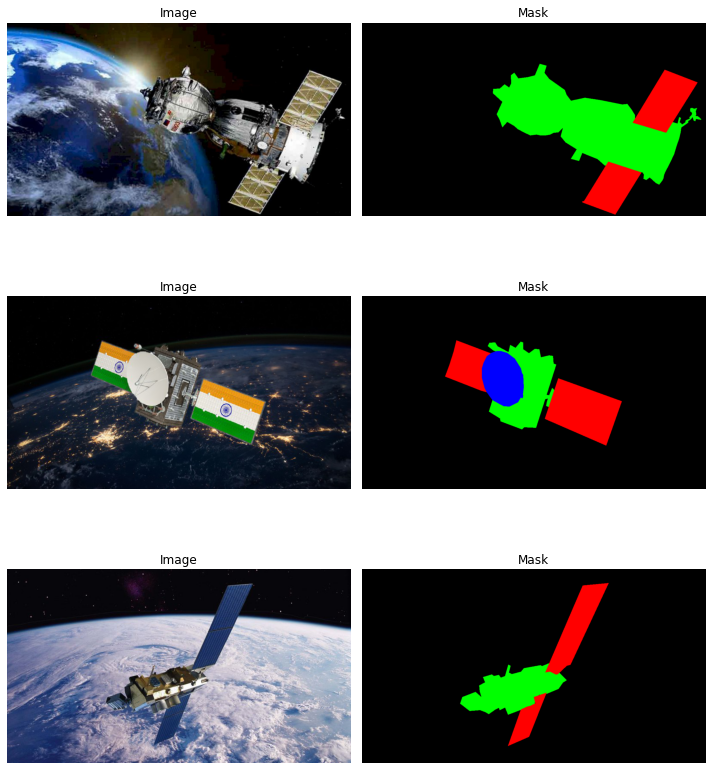

Val


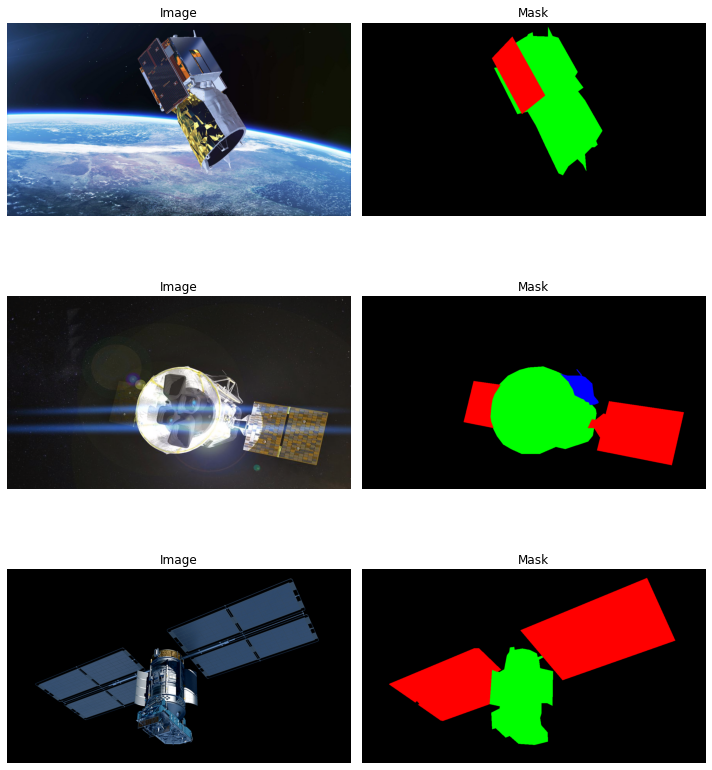

In [12]:
print('Train')
display_few_examples_from_data(train_dataset)
print('Val')
display_few_examples_from_data(val_dataset)

### Выбираем аугментации для обучения

Будем использовать библиотеку segmentation_models_pytorch. Первым шагом проведём препроцессинг имеющихся данных для работы с предобученными энкодерами.

In [13]:
def to_tensor(x, **kwargs):
    # [H,W,C] --> [C,H,W]
    return x.transpose(2,0,1).astype('float32')
    

def get_preprocessing(preprocessing_fn):
    _transform = [A.Lambda(image=preprocessing_fn),
                  A.Lambda(image=to_tensor, mask=to_tensor)]
    return A.Compose(_transform)
    
preprocessing_fn = smp.encoders.get_preprocessing_fn('timm-res2net50_26w_4s', pretrained='imagenet')

На космических снимках мы не привязаны к линии горизонта, спутник может находиться в любом положении. Поэтому аугментацию изображений проводим по следующей логике:
1. Уменьшаем изображение до размера 512*512
2. Вращаем
3. Добавляем шум и блюр
4. Меняем яркость, цвет, контраст

In [14]:

train_transform = A.Compose([
    A.Resize(512,512),
    
    A.HorizontalFlip(p=0.5),
    
    A.OneOf([
        A.VerticalFlip(p=1),
        A.RandomRotate90(p=1),
        A.Transpose(p=1),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=(-45,45),
                          shift_limit=0.2, p=0.5)
    ], p=0.8),
    
    A.OneOf([
        A.GaussNoise(p=0.5),
        A.Blur(blur_limit=3, p=0.5)
    ], p=0.5),
    
    A.OneOf([
        A.RandomGamma(p=1),
        A.RandomBrightnessContrast(brightness_limit=0.3,
                               contrast_limit=0.3, p=1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25,
                  b_shift_limit=25, p=0.8),
        A.CLAHE(p=1)
         ], p=0.8)
])

train_dataset = SatellitesDataset(split = 'train',
                                  transforms = train_transform,
                    preprocessing = get_preprocessing(preprocessing_fn))

val_transform = A.Compose([
     A.Resize(512, 512)
])

val_dataset = SatellitesDataset(split = 'val',
                                transforms = val_transform,
                    preprocessing = get_preprocessing(preprocessing_fn))

### Обучение модели

Было проведено большое количество экспериментов с различными моделями энкодеров, декодеров, функций ошибки, оптимизаторов. 
Для финального обучения были выбраны следующие параметры:
- В качестве модели используем Unet
- Энкодер timm-res2net50_26w_4s
- Функция ошибки DiceLoss
- Оптимизатор RAdam
- Каждые 10 эпох будем снижать шаг обучения

In [15]:
class SegModel(pl.LightningModule):
    def __init__(self, train_dataset, val_dataset):
        super(SegModel, self).__init__()
        self.batch_size = 2
        self.learning_rate = 0.001
        
        self.net = smp.Unet(encoder_name = 'timm-res2net50_26w_4s',
                            encoder_weights='imagenet',
                            classes=3,
                            in_channels=3)

        self.trainset = train_dataset
        self.valset = val_dataset
       
        self.criterion = smp.losses.DiceLoss(mode='multilabel', classes=3)
        self.metric = smp.utils.metrics.IoU(threshold=0.5)
        
    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        img, mask = batch
        out = self.forward(img)
        
        loss_train = self.criterion(out, mask.long())
        iou_score = self.metric(out, mask)
        
        self.log("train_loss", loss_train)
        self.log("train_iou", iou_score, prog_bar=True)
        
        return loss_train
    

    def configure_optimizers(self):
        opt = torch.optim.RAdam(self.net.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)

        return [opt], [sch]

    def train_dataloader(self):
        return DataLoader(self.trainset, 
                          batch_size=self.batch_size, 
                          shuffle=True, prefetch_factor=2)

    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=1, shuffle=False)

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        out = self.forward(img)
        
        loss_val = self.criterion(out, mask.long())
        iou_score = self.metric(out, mask)
        
        self.log("val_loss", loss_val, prog_bar=True)
        self.log("val_iou", iou_score, prog_bar=True, on_epoch=True)

In [16]:
model = SegModel(train_dataset, val_dataset)

trainer = pl.Trainer(
    gpus=1,
    #Проведём обучение на 50 эпохах
    max_epochs=50,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_iou"),
        LearningRateMonitor("epoch"),
        EarlyStopping(monitor="val_iou", mode="max", patience=15),
    ],  # Log learning rate every epoch
    progress_bar_refresh_rate=1,
    enable_checkpointing=True
)

trainer.fit(model)

D:\Users\shitd\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
#167 - Unet + DiceLoss AdamW resnext50 0.629 
#168 - Unet + JaccardLoss AdamW resnext50 0.607
#192 - Unet + FocalLoss 10ep smalldataset 0.45
#204 - Unet + DiceLoss smalldataset BGR 10 ep 0.48
#207 - Unet + FocalLoss smalldataset BGR 10 ep RAdam 0.46
#217 - PSPNet + DiceLoss smalldataset 10ep AdamW 0.57
#220 - PSPNet + DiceLoss 10ep resnet50 0.32
#223 - PSPNet + DiceLoss 5ep vgg19 0.14
#226 - PSPNet + FocalLoss 3ep vgg19 0.53
#232 - Unet + FocalLoss smalldataset vgg19 AdamW 5ep 0.31
#236 - Unet + FocalLoss smalldataset vgg19 RAdam 5ep 0.34
#239 - PSPNet + DiceLoss smalldataset efficientnet-b4 RAdam 5ep 0.505
#245 - PSPNet + JaccardLoss RAdam res2net50 0.45 
#250 - PSPNet + DiceLoss RAdam res2net50  0.66
#263 - PSPNet + JaccardLoss RAdam res2net50 0.53
#264 - Unet + DiceLoss RAdam res2net50 0.58

In [17]:
trainer.validate(model, 
                 ckpt_path="lightning_logs/version_267/checkpoints/epoch=47-step=60432.ckpt", 
                 dataloaders=model.val_dataloader())

Restoring states from the checkpoint path at lightning_logs/version_267/checkpoints/epoch=47-step=60432.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at lightning_logs/version_267/checkpoints/epoch=47-step=60432.ckpt
D:\Users\shitd\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_iou            0.7438129186630249
        val_loss            0.14879071712493896
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.14879071712493896, 'val_iou': 0.7438129186630249}]

### Визуализация предсказаний

In [19]:
model = SegModel(train_dataset, val_dataset)
checkpoint = torch.load('lightning_logs/version_267/checkpoints/epoch=47-step=60432.ckpt',
                        map_location = lambda storage, loc : storage)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


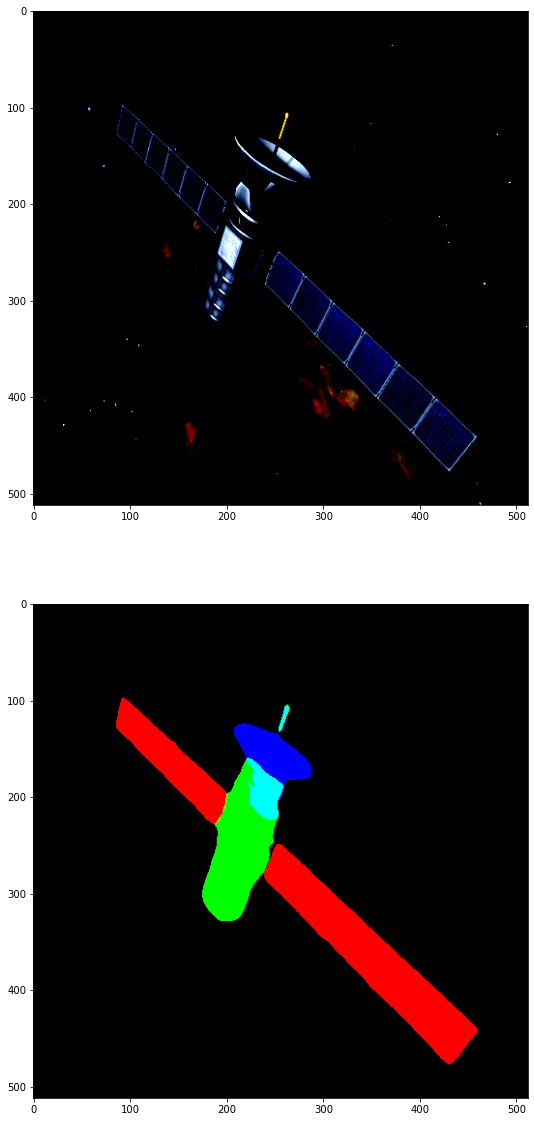

In [35]:
#62, 44
testloader = model.val_dataloader()
#Достаём из даталоадера изображение
for index, obj in enumerate(iter(testloader)):
    if index == 12:
        img = obj
        break
#Отправляем в модель        
img = img[0].float().cuda()
model.cuda()
model.net.eval()
with torch.no_grad():
    y = model.forward(img)
    mask_pred = y.cpu().detach().numpy()
    mask_pred = mask_pred.squeeze(0).transpose(1,2,0)

img2 = img.transpose(1, 2).transpose(2, 3).detach().cpu().numpy()
#Визуализируем предсказание
fig, axes = plt.subplots(2, 1, figsize=(20,20))
axes[0].imshow(img2[0])
axes[1].imshow(mask_pred)

plt.savefig('output_final.png')
plt.show()    

### Вывод

В результате проделанной работы была получена модель для сегментации  космических аппаратов. Проверялись следующие архитектуры:
1. FPN
2. PSPNet
3. Unet

PSPNet выигрывает по скорости работы, но не даёт результат выше 0,66. FPN дала примерно такие же показатели, но скорость работы как у Unet.

Основной загвоздкой в проекте стал подбор энкодера. Модель упорно игнорировала спутниковые антенны, относя их корпусу спутника. К тому же энкодер подбирался с оглядкой на производительность (используется GTX970 c 4Gb видеопамяти). Например vgg19 увеличивал время одной эпохи до 30 минут.

Итоговое обучение модели на 50 эпохах заняло 17 часов))) 

Что можно сделать для улучшения работы модели:
1. увеличить датасет для обучения
2. продолжить эксперименты с энкодерами
3. добавить ещё вариантов аугментации